# MNIST Fashion Dataset: A ConvNet Classifier

In [73]:
import gzip
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
plt.ioff()
from typing import *

## Dataset

In [74]:
def read_features(fname: str, num: int, img_size: int = 28) -> np.matrix:
    """Read `num` images from the dataset and return them as an `np.matrix` of size (num, img_size * img_size)"""
    with gzip.open(fname) as f:
        f.read(16)
        data: np.ndarray = np.frombuffer(f.read(img_size * img_size * num), dtype=np.uint8).astype(np.float32)
        data = data.reshape(num, img_size, img_size, 1)
    return data

def read_labels(fname: str, num: int, label_size: int = 1) -> np.matrix:
    """Read `num` labels from the dataset and return them as an `np.matrix` of size (num, label_size)"""
    with gzip.open(fname) as f:
        f.read(8)
        labels: np.ndarray = np.frombuffer(f.read(num * label_size), dtype=np.uint8).astype(np.uint8)
        labels = labels.reshape(num, label_size)
    return labels

In [75]:
X_TRAIN: np.ndarray = read_features('data/train-images-idx3-ubyte.gz', 60_000)
Y_TRAIN: np.ndarray = read_labels('data/train-labels-idx1-ubyte.gz', 60_000)
X_TEST: np.ndarray  = read_features('data/t10k-images-idx3-ubyte.gz', 10_000)
Y_TEST: np.ndarray  = read_labels('data/t10k-labels-idx1-ubyte.gz', 10_000)

In [76]:
def normalize_features(x: np.ndarray) -> np.matrix:
    """Normalizes the features to be fed into the neural network"""
    mu: np.ndarray = np.mean(x, axis=0)
    sigma: np.ndarray = np.max(x, axis=0) - np.min(x, axis=0)
    sigma[sigma < 1] = 1
    return (x - mu) / sigma

In [77]:
X_TRAIN = normalize_features(X_TRAIN)
X_TEST = normalize_features(X_TEST)

C:\Users\m4ttm\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


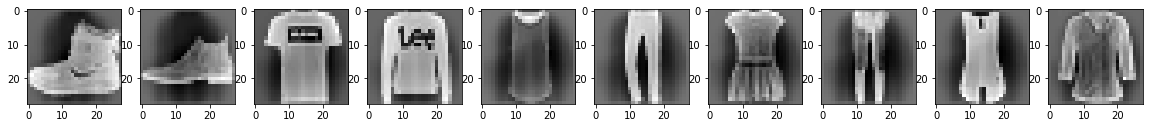

In [78]:
plt.figure(figsize=(20, 4))
plt.subplot(1, 10, 1)
for i in range(5):
    plt.subplot(1, 10, i*2+1)
    plt.imshow(X_TRAIN[i], cmap='gray')
    plt.subplot(1, 10, i*2+2)
    plt.imshow(X_TEST[i], cmap='gray')
plt.show()

## Training Functions

## Network

### Activation Functions

In [79]:
def sigmoid(z: np.ndarray) -> np.ndarray:
    """Applies the logistic sigmoid function to the given values"""
    return 1 / (1 + np.exp(-z))

def sigmoid_g(z: np.ndarray) -> np.ndarray:
    """Computes the gradients of the sigmoid function"""
    return sigmoid(z) * (1 - sigmoid(z))

def tanh(z: np.ndarray) -> np.ndarray:
    """Applies the TanH activation function to the given values"""
    return np.tanh(z)

def tanh_g(z: np.ndarray) -> np.ndarray:
    """Computes the gradients of the TanH function"""
    return 1 - tanh(z) ** 2

def relu(z: np.ndarray) -> np.ndarray:
    """Applies the ReLU activation function to the given values"""
    return z.clip(0)

def relu_g(z: np.ndarray) -> np.ndarray:
    """Computes the gradients of the ReLU function"""
    r: np.ndarray = np.zeros(z.shape)
    r[z>0] = 1
    return r

### Loss Function (& Activation Function)

In [80]:
def softmax(z: np.ndarray) -> np.ndarray:
    """Applies the softmax activation function to the given values"""
    return np.exp(z) / np.sum(np.exp(z), axis=0)

def loss(p: np.ndarray, y: np.ndarray, lam: float = 0, weights: List[np.ndarray] = []) -> float:
    """Compute the (regularized) CCE for the given predictions + labels"""
    return (-1/y.shape[0]) * np.sum(np.log(np.take_along_axis(p.T, y, axis=1))) + (lam/(2 * y.shape[0])) * sum(np.sum(w ** 2) for w in weights)

def softmax_loss_g(p: np.ndarray, y: np.ndarray) -> np.ndarray:
    """Compute the neurons' gradients with regard to the loss (softmax has to be applied before loss computation)"""
    grad: np.ndarray = softmax(p)
    np.put_along_axis(grad.T, y, np.take_along_axis(grad.T, y, axis=1) - 1, axis=1)     # subtract 1 from the "label" neurons
    return (1/y.shape[0]) * grad                                                        # return the gradients normalized by the batch size

### Weight Initialization Functions

In [81]:
def uniform_init(inp: int, out: int, shape: List[int]) -> np.ndarray:
    """
    Generates initalized weights of a given shape
    :param inp: The number of inputs
    :param out: The number of outputs
    :param shape: The shape of the weights to be initialized
    :return: The uniformly randomly initalized weights
    """
    return np.random.uniform(-1, 1, shape)

def standard_init(inp: int, out: int, shape: List[int]) -> np.ndarray:
    """
    Generates initalized weights of a given shape
    :param inp: The number of inputs
    :param out: The number of outputs
    :param shape: The shape of the weights to be initialized
    :return: The "Standard"-initalized weights
    """
    return np.random.uniform(-1, 1, shape) * np.sqrt(1 / inp)

def xavier_init(inp: int, out: int, shape: List[int]) -> np.ndarray:
    """
    Generates initalized weights of a given shape
    :param inp: The number of inputs
    :param out: The number of outputs
    :param shape: The shape of the weights to be initialized
    :return: The "Xavier"-initalized weights
    """
    return np.random.uniform(-1, 1, shape) * np.sqrt(6 / (inp + out))

def he_init(inp: int, out: int, shape: List[int]) -> np.ndarray:
    """
    Generates initalized weights of a given shape
    :param inp: The number of inputs
    :param out: The number of outputs
    :param shape: The shape of the weights to be initialized
    :return: The "He"-initalized weights
    """
    return np.random.uniform(-1, 1, shape) * np.sqrt(2 / inp)

### Layer Classes

In [82]:
class Layer(object):
    """
    Represents a layer in a deep neural network.
    """

    def __init__(self, actf: Callable[[np.ndarray], np.ndarray] = relu, actf_g: Callable[[np.ndarray], np.ndarray] = relu_g,
                 initializer: Callable[[int, int, List[int]], np.ndarray] = he_init):
        """
        Create a new layer.
        :param actf: The activation function to use
        :param actf_g: The activation function's derivation
        :param initializer: The weight initializer to use
        :param inp_shape: The shape of the layer's input
        """
        self.actf: Callable[[np.ndarray], np.ndarray] = actf
        self.actf_g: Callable[[np.ndarray], np.ndarray] = actf_g
        self.initializer: Callable[[int, int, List[int]], np.ndarray] = initializer
        self.weights: Optional[np.ndarray] = None

    def initialize(self) -> None:
        """Initializes the weights"""
        raise NotImplementedError()

    def forward(self, inp: np.ndarray) -> np.ndarray:
        """Perform forward propagation + return the results."""
        raise NotImplementedError()
    
    def backward(self, grad: np.ndarray, val: np.ndarray) -> np.ndarray:
        """Perform backward propagation + return the results."""
        raise NotImplementedError()
    
    def __call__(self, inp: np.ndarray) -> np.ndarray:
        """Perform forward propagation + return the results."""
        return self.forward(inp) 

In [83]:
class FCLayer(Layer):
    """
    Represents a fully-connected layer in a deep neural network.
    """

    def __init__(self, neurons: int, actf: Callable[[np.ndarray], np.ndarray] = relu, actf_g: Callable[[np.ndarray], np.ndarray] = relu_g,
                 initializer: Callable[[int, int, List[int]], np.ndarray] = he_init, inp_shape: Optional[Tuple[int]] = None):
        """
        Create a new fully-connected layer.
        :param neurons: The number of neurons in the layer
        :param actf: The activation function to use
        :param actf_g: The activation function's derivation
        :param initializer: The weight initializer to use
        :param inp_shape: The shape of the layer's input - format (#neurons)
        """
        self.neurons: int = neurons
        super().__init__(actf, actf_g, initializer)
        self.inp_shape: Optional[Tuple[int]] = inp_shape

    @property
    def out_shape(self) -> Tuple[int]:
        return ( self.neurons, )

    def initialize(self) -> None:
        """Initializes the weights"""
        if self.inp_shape is None:
            return
        self.weights = self.initializer(self.inp_shape[0] + 1, self.neurons, [ self.inp_shape[0] + 1, self.neurons, ])

    def forward(self, inp: np.ndarray) -> np.ndarray:
        """Perform forward propagation + return the results."""
        return self.actf(self._forward(inp))

    def _forward(self, inp: np.ndarray) -> np.ndarray:
        """Perform forward propagation - without applying the activation function."""
        assert len(inp.shape) == 2
        assert inp.shape[0] == self.inp_shape[0]
        return self.weights.T @ np.vstack((inp, np.ones(inp.shape[1])))
    
    def backward(self, grad: np.ndarray, val: np.ndarray) -> np.ndarray:
        """
        Perform backward propagation + return the results.
        :param grad: The gradient of the next layer
        :param val: This layer's value (= before application of activation function)
        :return: This layer's gradient
        """
        assert len(grad.shape) == 2
        assert grad.shape == val.shape
        assert grad.shape[0] == self.neurons
        return self.weights[:-1, :] @ (grad * self.actf_g(val))

    def _backward(self, grad: np.ndarray, val: np.ndarray, p_act: np.ndarray, lam: float) -> np.ndarray:
        """
        Perform backward propagation - but return the weight's gradients.
        :param grad: The gradient of the next layer
        :param val: This layer's value (= before application of activation function)
        :param p_act: The previous layer's activation
        :param lam: The regularization parameter lambda - for weight regularization
        :return: This layer's gradient
        """
        assert len(grad.shape) == 2
        assert grad.shape == val.shape
        assert grad.shape[0] == self.neurons
        assert p_act.shape[1] == val.shape[1]
        assert p_act.shape[0] == self.inp_shape[0]
        return np.vstack((p_act, np.ones(p_act.shape[1]))) @ (grad * self.actf_g(val)).T + (lam/val.shape[1]) * self.weights

    def __call__(self, inp: np.ndarray) -> np.ndarray:
        """Perform forward propagation + return the results."""
        return self.forward(inp) 

    def __setattr__(self, name: str, value: Any) -> None:
        if name == 'inp_shape' and value and len(value) != 1:
            raise TypeError()
        elif name in ('neurons', 'inp_shape'):
            self.__dict__[name] = value
            if 'neurons' in self.__dict__.keys() and 'inp_shape' in self.__dict__.keys():
                self.initialize()
            return
        elif name == 'initializer':
            self.__dict__[name] = value
            if 'shape' in self.__dict__.keys() and 'inp_shape' in self.__dict__.keys():
                self.initialize()
            return
        super().__setattr__(name, value)

In [84]:
class ConvLayer(Layer):
    """
    Represents a convolutional layer in a deep neural network.
    """

    def __init__(self, shape: Tuple[int, int, int], stride: int, pad: int = 0, 
                 actf: Callable[[np.ndarray], np.ndarray] = relu, actf_g: Callable[[np.ndarray], np.ndarray] = relu_g,
                 initializer: Callable[[int, int, List[int]], np.ndarray] = he_init, inp_shape: Optional[Tuple[int, int, int]] = None):
        """
        Create a new convolutional layer.
        :param shape: The shape of the layer's filters - format (#filters x height x width)
        :param stride: The filters' stride
        :param actf: The activation function to use
        :param actf_g: The activation function's derivation
        :param initializer: The weight initializer to use
        :param inp_shape: The shape of the layer's input - format (height x width x #channels)
        """
        self.shape: List[int] = shape
        self.stride: int = stride
        self.pad: int = pad
        super().__init__(actf, actf_g, initializer)
        self.inp_shape: Optional[Tuple[int, int, int]] = inp_shape

    @classmethod
    def _convolve(cls, x: np.ndarray, f: np.ndarray, p: int = 0, s: int = 1) -> np.ndarray:
        """
        Perform convolution + return result.
        :param x: The base array to convolve on - shape: ( #inputs, height, width, #channels )
        :param f: The filter(s) to use - shape: ( #filters, height, width, #channels )
        :param p: The padding (added on all sides) - default: 0
        :param s: The stride - default: 0
        """
        assert len(x.shape) == 4
        padded: np.ndarray = np.pad(x, [(0, 0), *((p,)*2,)*2, (0, 0)])
        strides: np.ndarray = np.lib.stride_tricks.sliding_window_view(padded, (x.shape[0], *f.shape[1:]))
        strides = np.moveaxis(np.repeat(strides.reshape(*strides.shape[1:3], x.shape[0], 1, *strides.shape[5:7], f.shape[-1])[::s, ::s], 
                	                    f.shape[0], axis=3) * f, 2, 0)
        return np.sum(strides.reshape(*strides.shape[:4], -1), axis=4)

    @classmethod
    def _full_convolve(cls, x: np.ndarray, f: np.ndarray) -> np.ndarray:
        """
        Perform "full" convolution + return result.
        :param x: The base array to convolve on - shape: ( #inputs, height, width, #channels )
        :param f: The filter(s) to use - shape: ( #filters, height, width, #channels )
        """
        return cls._convolve(x, f, f.shape[1] - 1)

    @property
    def out_shape(self) -> Tuple[int, int, int]:
        return ( int(1 + (self.inp_shape[0] + 2 * self.pad - self.shape[1]) / self.stride),
                 int(1 + (self.inp_shape[1] + 2 * self.pad - self.shape[2]) / self.stride),
                 self.shape[0], )

    def initialize(self) -> None:
        """Initializes the weights"""
        if self.inp_shape is None:
            raise TypeError()
        filters_size: int = reduce(lambda x, y: x*y, self.shape)
        self.weights = self.initializer(filters_size * self.inp_shape[2], filters_size, [ *self.shape, self.inp_shape[2], ])
    
    def forward(self, inp: np.ndarray) -> np.ndarray:
        """Perform forward propagation + return the results."""
        return self.actf(self._forward(inp))

    def _forward(self, inp: np.ndarray) -> np.ndarray:
        """Perform forward propagation - without applying the activation function."""
        assert inp.shape[1:] == self.inp_shape
        return self._convolve(inp, self.weights, self.pad, self.stride)

    def backward(self, grad: np.ndarray, val: np.ndarray) -> np.ndarray:
        """
        Perform backward propagation + return the results.
        :param grad: The gradient of the next layer
        :param val: This layer's value (= before application of activation function)
        :return: This layer's gradient
        """
        assert grad.shape[1:] == self.out_shape
        assert val.shape[1:] == self.out_shape
        return self._full_convolve(grad * self.actf_g(val), np.swapaxes(np.flip(self.weights, axis=(1,2)), 0, 3))

    def _backward(self, grad: np.ndarray, val: np.ndarray, p_act: np.ndarray, lam: float) -> np.ndarray:
        """
        Perform backward propagation - but return the weight's gradients.
        :param grad: The gradient of the next layer
        :param val: This layer's value (= before application of activation function)
        :param p_act: The previous layer's activation
        :param lam: The regularization parameter lambda - for weight regularization
        :return: This layer's gradient
        """
        assert grad.shape[1:] == self.out_shape
        assert val.shape[1:] == self.out_shape
        return self._convolve(np.swapaxes(p_act, 0, 3), np.swapaxes(grad * self.actf_g(val), 0, 3), 0, self.stride).swapaxes(0, 3) + (lam/val.shape[1]) * self.weights

    def __call__(self, inp: np.ndarray) -> np.ndarray:
        """Perform forward propagation + return the results."""
        return self.forward(inp) 

    def __setattr__(self, name: str, value: Any) -> None:
        if name in ('shape', 'inp_shape',) and value:
            if len(value) != 3:
                raise TypeError()
            else:
                self.__dict__[name] = value
                if 'shape' in self.__dict__.keys() and 'inp_shape' in self.__dict__.keys():
                    self.initialize()
                return
        elif name == 'initializer':
            self.__dict__[name] = value
            if 'shape' in self.__dict__.keys() and 'inp_shape' in self.__dict__.keys():
                self.initialize()
            return
        super().__setattr__(name, value)

In [85]:
class FlattenLayer(Layer):
    """
    Flattens the output of a previous layer in a neural network.
    """

    def __init__(self, inp_shape: Optional[Tuple[int, int, int]] = None):
        """
        Create a new flatten layer.
        :param inp_shape: The shape of the layer's input - format (height x width x #channels)
        """
        self.inp_shape: Optional[Tuple[int, int, int]] = inp_shape
        self.actf: Callable[[np.ndarray], np.ndarray] = lambda z: z
        self.actf_g: Callable[[np.ndarray], np.ndarray] = lambda z: np.ones(z.shape)
        self.weights = np.ndarray([ 0, ])

    @property
    def out_shape(self) -> Tuple[int]:
        return ( reduce(lambda a,b: a*b, self.inp_shape), )

    def initialize(self) -> None:
        """Dummy function - layer has no weights"""
        pass

    def forward(self, inp: np.ndarray) -> np.ndarray:
        """Perform forward propagation + return the results."""
        return self._forward(inp)

    def _forward(self, inp: np.ndarray) -> np.ndarray:
        """Perform forward propagation - without applying the activation function."""
        return inp.reshape(-1, *self.out_shape).T

    def backward(self, grad: np.ndarray, *args: List[Any]) -> np.ndarray:
        """
        Perform backward propagation + return the results.
        :param grad: The gradient of the next layer
        :return: This layer's gradient (= the reshaped gradient)
        """
        return grad.reshape(-1, *self.inp_shape)

    def _backward(self, *args: List[Any]) -> np.ndarray:
        """
        Perform backward propagation - but return the weight's gradients.
        (In this case, it's just "dummy" backward propagation - there are no weights to update)
        :return: This layer's dummy gradient
        """
        return np.ndarray([ 0, ])

    def __call__(self, inp: np.ndarray) -> np.ndarray:
        """Perform forward propagation + return the results."""
        return self.forward(inp)

### Network Class

In [86]:
class Network(object):
    """
    Represents a deep neural network.
    """

    def __init__(self, initializer: Callable[[List[int]], List[np.ndarray]] = he_init, layers: List[Layer] = []):
        """
        Create a new deep neural network.
        :param initializer: The weight initializer to use
        :param layers: The network's layers
        """
        self.__initializer: Callable[[List[int]], List[np.ndarray]] = initializer
        self.layers: List[Layer] = layers

    @property
    def inp_shape(self) -> List[int]:
        return self.layers[0].inp_shape if self.layers else None

    @property
    def out_shape(self) -> List[int]:
        return self.layers[-1].out_shape if self.layers else None

    @classmethod
    def make_class(cls, p: np.ndarray) -> np.ndarray:
        """Turns the raw output of the network into actual class numbers"""
        return np.argmax(p, axis=0).reshape(-1, 1)

    def initialize(self) -> None:
        """Re-initialize all weights"""
        for l in self.layers:
            l.initialize()

    def __prepare_layer(self, layer: Layer) -> None:
        if self.layers:
            layer.inp_shape = self.out_shape
        layer.initializer = self.__initializer

    def append(self, layer: Layer) -> None:
        """Appends a new layer to the network"""
        self.__prepare_layer(layer)
        self.layers.append(layer)
        self.initialize()

    def insert(self, idx: int, layer: Layer) -> None:
        """Inserts the given layer at the given index"""
        self.__prepare_layer(layer)
        self.layers.insert(idx, layer)
        self.initialize()

    def forward(self, x: np.ndarray) -> np.ndarray:
        """Perform forward propagation using the given input"""
        out: np.ndarray = x
        for l in self.layers:
            out = l(out)
        return out

    def accuracy(self, p: np.ndarray, y: np.ndarray) -> float:
        """Calculates the accuracy of the given predictions [%]"""
        assert p.shape == y.shape
        return 1 - (np.count_nonzero(p - y) / y.shape[0])

    def step(self, x: np.ndarray, y: np.ndarray, loss_g: Callable[[np.ndarray, np.ndarray], np.ndarray], lam: float = .03):
        """
        Take a single training step - i.e. complete a training epoch and return the computed gradients
        :param x: A mini-batch of features
        :param y: The labels for the mini-batch
        :param loss_g: The loss (+ last layer's activation function's) derivation
        :param lam: The regularization parameter lambda - for weight regularization
        :return: The weights' computed gradients
        """

        l_val: List[np.ndarray] = [ x, ]
        l_act: List[np.ndarray] = [ x, ]

        for l in self.layers:
            l_val.append(l._forward(l_act[-1]))
            l_act.append(l.actf(l_val[-1]))
        
        l_grad: List[np.ndarray] = [ loss_g(l_val[-1], y), ]
        w_grad: List[np.ndarray] = []

        for i, l in enumerate(reversed(self.layers), 1):
            w_grad.append(l._backward(l_grad[-1], l_val[-i], l_act[-i-1], lam))
            l_grad.append(l.backward(l_grad[-1], l_val[-i]))

        return list(reversed(w_grad))

    def train(self, x: np.ndarray, y: np.ndarray, optimizer: Callable[..., np.ndarray], epochs: int,
              loss: Callable[[np.ndarray, np.ndarray, float, List[np.ndarray]], float],
              loss_g: Callable[[np.ndarray, np.ndarray], np.ndarray], 
              batch_size: int = 32, lam: float = .03, all_loss: bool = False,
              **kwargs: Dict[str, Any]) -> Optional[Tuple[List[float], List[float]]]:
        """
        Perform Mini-Batch Gradient Descent on the given dataset using the given weights & parameters
        :param x: The feature part of the dataset
        :param y: The labels of the dataset
        :param optimizer: The optimizer to use for weight adjustion
        :param epochs: The number of epochs to train for
        :param batch_size: The batch-size to use for mini-batch gradient descent
        :param lam: The regularization parameter lambda - for weight regularization
        :param all_loss: Compute + return a list of losses for every epoch
        :return: Optionally loss + accuracy per epoch
        """
        losses: List[float] = []
        accuracies: List[float] = []

        for i in range(epochs):
            choices: np.ndarray = np.random.choice(np.arange(x.shape[0]), batch_size)
            if i%(epochs//10) == 0:
                print(f'[{i:04d}/{epochs:04d}] Loss = {loss(self(x[choices]), y[choices])} ... ')
            if all_loss and i%(epochs//100) == 0:
                losses.append(loss(self(x[choices]), y[choices]))
                accuracies.append(self.accuracy(self.make_class(self(x[choices])), y[choices]))
            grad: List[np.matrix] = self.step(x[choices], y[choices], loss_g, lam)
            for j, l in enumerate(self.layers):
                l.weights = optimizer(l.weights, grad[j], j, **kwargs)
        
        if all_loss:
            return losses, accuracies

    def __call__(self, inp: np.ndarray) -> np.ndarray:
        """Perform forward propagation + return the results."""
        return self.forward(inp) 

    def __add__(self, other: Any) -> Any:
        if not isinstance(other, Layer):
            raise ArithmeticError()
        self.__prepare_layer(other)
        return Network(self.__initializer, [ *self.layers.copy(), other, ])

    def __iadd__(self, other: Any) -> None:
        if not isinstance(other, Layer):
            raise ArithmeticError()
        self.append(other)
        return self

    def __len__(self) -> int:
        return len(self.layers)

    def __getitem__(self, key: int) -> Layer:
        return self.layers[key]

    def __setitem__(self, key: int, value: Layer) -> None:
        if key > 0:
            value.inp_shape = self[key-1].out_shape
        self.layers[key] = value
        self.initialize()
    
    def __delitem__(self, key: int) -> None:
        del self.layers[key]
        self.initialize()

    def __del__(self):
        del self[:]

    def __str__(self) -> str:
        return 'DNN{ ' + ' --> '.join(f'{l.__class__.__name__}{l.out_shape}' for l in self.layers) + ' }'

### Optimizers

In [87]:
def vanilla(weight: np.ndarray, grad: np.ndarray, i: int, alpha: float) -> np.ndarray:
    """
    Given a weight matrix and its gradient, perform vanilla gradient descent
    :param weight: The weight matrix connecting two layers in a neural net
    :param grad: The corresponding gradients
    :param i: The index of the weights that are being updated
    :param alpha: The learning rate "alpha"
    :return: The new weight matrix
    """
    return weight - alpha * grad

def make_momentum(layers: List[Layer], gamma: float) -> Callable[[np.ndarray, np.ndarray, float], np.ndarray]:
    """
    Wrapper function to create a new gradient descent w. momentum optimizer
    :param neurons: The number of neurons at each layer - the network's shape
    :param gamma: The hyperparameter for momentum decay
    :return: An instance of a momentum optimizer
    """
    v: List[np.ndarray] = [ np.zeros(l.weights.shape) for l in layers ]

    def momentum(weight: np.ndarray, grad: np.ndarray, i: int, alpha: float) -> np.ndarray:
        """
        Given a weight matrix and its gradient, perform gradient descent w. momentum
        :param weight: The weight matrix connecting two layers in a neural net
        :param grad: The corresponding gradients
        :param i: The index of the weights that are being updated
        :param alpha: The learning rate "alpha"
        :return: The new weight matrix
        """ 
        v[i] = gamma * v[i] + alpha * grad
        return weight - v[i]
    
    return momentum

def make_adam(layers: List[Layer], beta1: float, beta2: float, epsilon: float = 1e-7) -> Callable[[np.ndarray, np.ndarray, float], np.ndarray]:
    """
    Wrapper function to create a new Adam optimizer
    :param neurons: The number of neurons at each layer - the network's shape
    :param beta1: The hyperparameter for first order moment decay
    :param beta2: The hyperparameter for second order moment decay
    :param epsilon: A hyperparameter to prevent divisions by zero
    :return: An instance of an Adam optimizer
    """
    m: List[np.ndarray] = [ np.zeros(l.weights.shape) for l in layers ]
    v: List[np.ndarray] = [ np.zeros(l.weights.shape) for l in layers ]

    def adam(weight: np.ndarray, grad: np.ndarray, i: int, alpha: float) -> np.ndarray:
        """
        Given a weight matrix and its gradient, perform gradient descent w. AdaDelta
        :param weight: The weight matrix connecting two layers in a neural net
        :param grad: The corresponding gradients
        :param i: The index of the weights that are being updated
        :param alpha: The learning rate "alpha"
        :return: The new weight matrix
        """
        m[i] = beta1 * m[i] + (1 - beta1) * grad
        v[i] = beta2 * v[i] + (1 - beta2) * np.power(grad, 2)
        m_s: np.ndarray = m[i] / (1 - beta1)
        v_s: np.ndarray = v[i] / (1 - beta2)
        return weight - alpha * np.multiply(m_s, 1 / np.sqrt(v_s + epsilon))

    return adam

## Training

In [88]:
n: Network = Network(initializer=he_init)

n += ConvLayer((4, 5, 5), 1, inp_shape=(28, 28, 1))
n += ConvLayer((8, 3, 3), 1)
n += ConvLayer((4, 3, 3), 1)
n += FlattenLayer(inp_shape=(28, 28, 1))
n += FCLayer(150)
n += FCLayer(10, actf=softmax, actf_g=lambda z: np.ones(z.shape))

print(n)

DNN{ ConvLayer(24, 24, 4) --> ConvLayer(22, 22, 8) --> ConvLayer(20, 20, 4) --> FlattenLayer(1600,) --> FCLayer(150,) --> FCLayer(10,) }


In [89]:
ALPHA: float        = .005      # the learning rate, α
LAMBDA: float       = .03       # the regularization parameter to prevent weights from exploding, λ
GAMMA: float        = .9        # a decay parameter for optimizers, γ
BETA1: float        = .9        # a decay parameter for Adam, β_1
BETA2: float        = .999      # a decay parameter for Adam, β_2
EPSILON: float      = 1e-7      # a parameter to prevent divison by zero in multiple optimizers, ε
BATCH_SIZE: int     = 64        # the batch size for multi-batch SGD
EPOCHS: int         = 256       # the number of epochs (= iterations) to train for

In [90]:
losses, accuracies = n.train(X_TRAIN, Y_TRAIN, make_adam(n.layers, BETA1, BETA2), EPOCHS, loss, softmax_loss_g, 
                             batch_size=BATCH_SIZE, lam=LAMBDA, all_loss=True, alpha=ALPHA)

[0000/0256] Loss = 2.3081984936409343 ... 
[0025/0256] Loss = 1.4931247150839955 ... 
[0050/0256] Loss = 1.4767187077669477 ... 
[0075/0256] Loss = 0.9233965782696495 ... 
[0100/0256] Loss = 1.2101644864628227 ... 
[0125/0256] Loss = 0.9510715759082085 ... 
[0150/0256] Loss = 0.7043076479107745 ... 
[0175/0256] Loss = 1.0368786786811093 ... 
[0200/0256] Loss = 0.7780110961483511 ... 
[0225/0256] Loss = 1.2123698037217552 ... 
[0250/0256] Loss = 1.0800783793454558 ... 


## Evaluation

In [92]:
def plot_loss_acc(losses: List[List[float]], accuracies: List[List[float]], legend: List[str], 
                  epochs: int, start: int = 0) -> None:
    """
    Plot losses + accuracies in respect to epochs - useful
    for comparison between different network strategies
    """
    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss / Epoch')
    for l in losses:
        plt.plot(np.linspace(start, epochs, len(l)), l)
    plt.legend(legend)
    plt.subplot(122)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy / Epoch')
    for a in accuracies:
        plt.plot(np.linspace(start, epochs, len(a)), a)
    plt.legend(legend)
    plt.show()

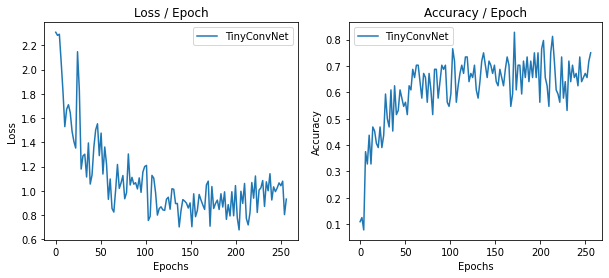

In [93]:
plot_loss_acc([ losses, ], [ accuracies, ], [ 'TinyConvNet', ], EPOCHS)

In [94]:
choices: np.ndarray = np.random.choice(np.arange(X_TRAIN.shape[0]), BATCH_SIZE*4)
print(f'[*] Training accuracy: {n.accuracy(n.make_class(n(X_TRAIN[choices])), Y_TRAIN[choices])*100:.3f}% ... ')
choices: np.ndarray = np.random.choice(np.arange(X_TEST.shape[0]), BATCH_SIZE*4)
print(f'[*] Testing accuracy: {n.accuracy(n.make_class(n(X_TEST[choices])), Y_TEST[choices])*100:.3f}% ... ')

[*] Training accuracy: 66.797% ... 
[*] Testing accuracy: 65.625% ... 


## Experiments